In this notebook, we train an autoregressive PixelCNN to model noise.


In [1]:
import os
import sys

import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
)
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

sys.path.append("../")
from noise_model.PixelCNN import PixelCNN
from utils.dataloaders import create_nm_loader
from utils.tools import view_receptive_field, autocorrelation

plt.style.use("dark_background")
plt.rc("figure", figsize=[20, 5])

Load noise samples (PBS)</br>
These should be numpy ndarrays of shape [Number, 1, Width] or [Number, Width]. </br>


In [2]:
at_pbs = np.load("./sample_data/PBS.npy")

# For our data, the scattering channel is the second
at_pbs = at_pbs[:, 1]
# We reshape it to fit pytorch's conventional input shape
at_pbs = at_pbs.reshape((4000, 1, 1000))

# The mean of noise should be zero, otherwise the denoiser will shift the data
at_pbs = at_pbs - np.mean(at_pbs)

Check temporal autocorrelation of noise. The recepetive field of the noise model doesn't have to span all timepoints correlated with each other, but should cover enough for an accurate model of the target timepoint.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


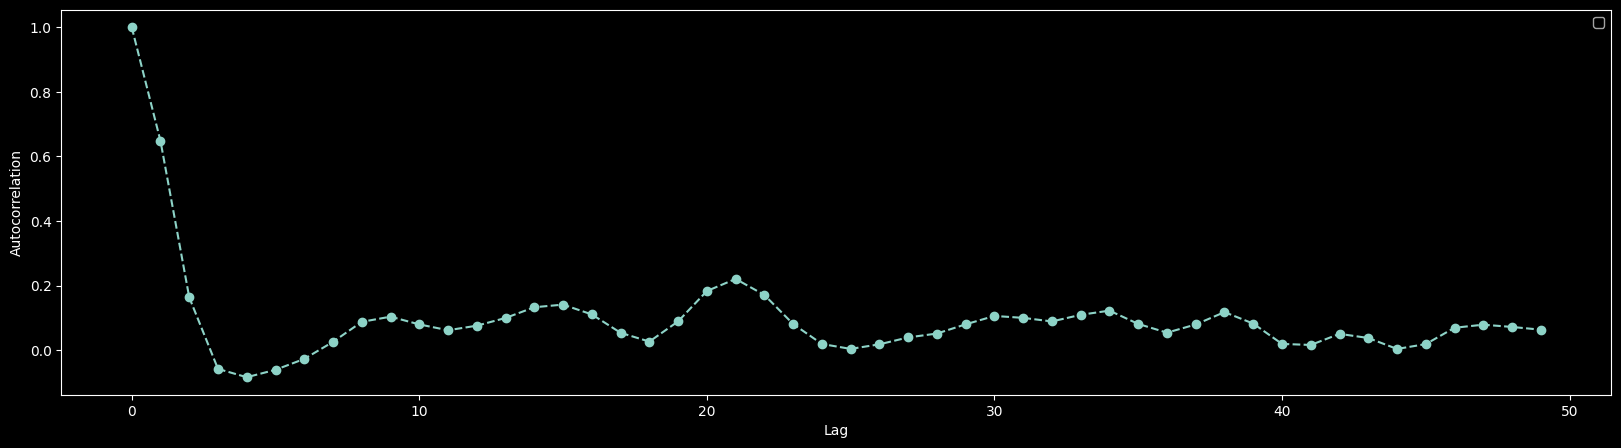

In [3]:
autocorrelation([at_pbs[0, 0]], max_lag=50)

Create data loaders and get the mean and standard deviation of the noise samples.</br>

In [4]:
nm_train_loader, nm_val_loader, noise_mean, noise_std = create_nm_loader(
    at_pbs, batch_size=32, split=0.8
)

Set noise model checkpoint directory. This is where training logs and the trained model will be saved.


In [5]:
nm_checkpoint_path = f"../nm_checkpoint"

Initialise trainer and noise model. We use the default parameters.

In [6]:
noise_model = PixelCNN(
    n_filters=8,
    kernel_size=11,
    n_gaussians=2,
    noise_mean=noise_mean,
    noise_std=noise_std,
    lr=2e-3,
)

use_cuda = torch.cuda.is_available()
trainer = pl.Trainer(
    default_root_dir=nm_checkpoint_path,
    accelerator="gpu" if use_cuda else "cpu",
    devices=1,
    max_epochs=1000,
    logger=TensorBoardLogger(nm_checkpoint_path),
    log_every_n_steps=len(nm_train_loader),
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(patience=50, monitor="val/nll"),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


View how many timepoints the receptive field of the noise model will cover. Correlations within this range will be modelled while correlations outside this range will not. The autocorrelation plot can help to determine if enough timepoints are included.
This shows the receptive field of the last point in the series.</br>
Change the `kernel_size` to change the receptive field.

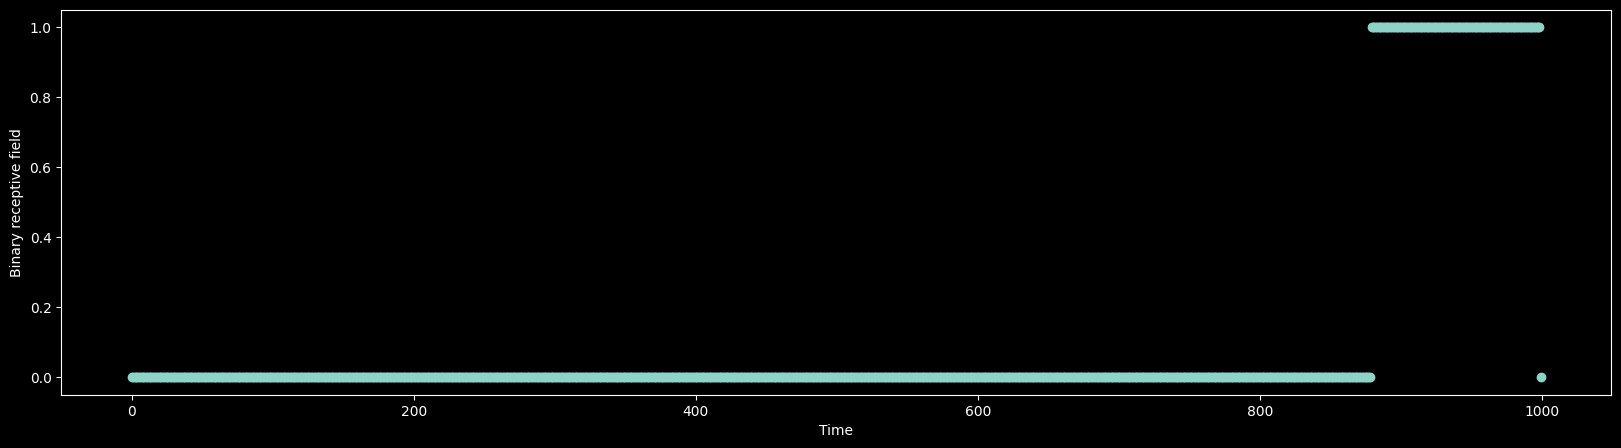

In [7]:
view_receptive_field(noise_model, at_pbs.shape[-1:])

Train and save final parameters</br>
Training logs can be monitored on Tensorboard. Open a terminal, activate the dnm conda environment with Tensorboard installed and enter `tensorboard --logdir path/to/autonoise/nm_checkpoint/` then open a browser and enter localhost:6006. 

The most important metric to monitor is the validation negative loglikelihood, or val/nll in Tensorboard. It should go down at the start of training and slowly level off. Training should end when the loss has plateaued.</br>
The following are some scenarios where training goes wrong and suggestions on how to fix them.</br>
1. The validation loss goes down smoothly but training stops before it has plateaued.</br>
If training has stopped because the trainer hit 500 epochs, we can change the `max_epochs` value in the above cell to a higher number.
If training stopped before the trainer hit 500 epochs, we can change the `EarlyStopping(patience)` value in the above cell to a higher number.

2. The validation loss goes down smoothly then sharply increases.</br>
The model has overfit to the training data. Try: 
    * Decreasing `n_filters` to reduce the capacity of the network. 
    * Training for fewer epochs or with a lower patience.

3. Validation loss does not go down smoothly or at all. Try:
    * Increasing `n_filters` to increase the capacity of the network.
    * Changing the `batch_size`in `create_nm_loader`.  
    * Changing the learning rate, `lr`, by a factor of 10.
    * Changing the number of Gaussians in the mixture model used for p(noise). Ideally, the `n_gaussians` variable should be set as low as possible to make training easier, but will need to be increased to describe complex noise. Try values from 1 to 10.


In [8]:
trainer.fit(noise_model, nm_train_loader, nm_val_loader)
trainer.save_checkpoint(os.path.join(nm_checkpoint_path, "final_params.ckpt"))

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | gatedconvs | Sequential | 8.9 K 
------------------------------------------
8.9 K     Trainable params
0         Non-trainable params
8.9 K     Total params
0.035     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ben/miniforge3/envs/dnm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


/home/ben/miniforge3/envs/dnm/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=35` in the `DataLoader` to improve performance.


Epoch 0:  16%|█▌        | 16/100 [00:00<00:02, 40.09it/s, v_num=1]

/home/ben/miniforge3/envs/dnm/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 204: 100%|██████████| 100/100 [00:01<00:00, 72.22it/s, v_num=1, val/nll=1.010]


: 